In [383]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [384]:
#loading test image
image = cv2.imread('images/answer_sheet_original_marked_one.jpg')

# Preprocessing

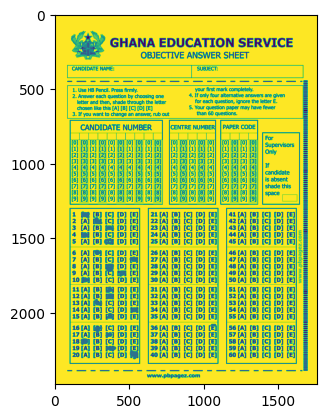

In [385]:
#converting to gray scale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray)

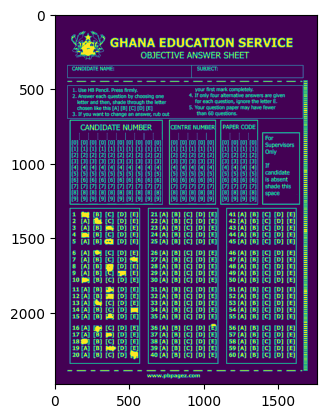

In [386]:
image_noise_reduction = cv2.GaussianBlur(image_gray, (5,5), 1)
_, binary = cv2.threshold(image_noise_reduction, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binary)

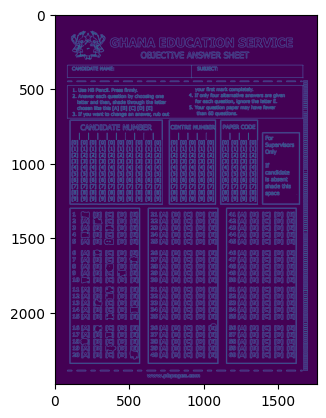

In [387]:
image_edges = cv2.Canny(binary, 10, 50)
plt.imshow(image_edges)

In [388]:
img_contours = image.copy()
contours, hierarchy = cv2.findContours(image_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [389]:
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 10)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

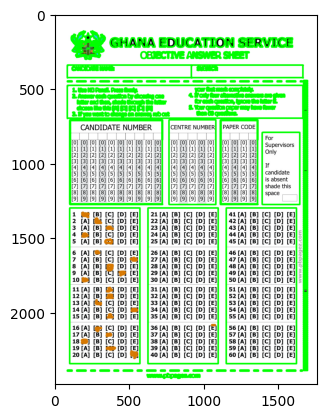

In [390]:
plt.imshow(img_contours)

In [401]:

def rectangle_contour(contours):
    rect_contours = []
    for i in contours:
        area = cv2.contourArea(i)
        if area>100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*peri, True)
            if len(approx) == 4:
                rect_contours.append(i)

    rect_contours = sorted(rect_contours, key=cv2.contourArea, reverse=True)
    return rect_contours

rectCon = rectangle_contour(contours)


[array([[[1150, 1300]],
 
        [[1149, 1301]],
 
        [[1148, 1302]],
 
        ...,
 
        [[1153, 1300]],
 
        [[1152, 1300]],
 
        [[1151, 1300]]], dtype=int32),
 array([[[ 625, 1300]],
 
        [[ 624, 1301]],
 
        [[ 623, 1302]],
 
        ...,
 
        [[ 628, 1300]],
 
        [[ 627, 1300]],
 
        [[ 626, 1300]]], dtype=int32),
 array([[[ 100, 1300]],
 
        [[  99, 1301]],
 
        [[  98, 1302]],
 
        ...,
 
        [[ 103, 1300]],
 
        [[ 102, 1300]],
 
        [[ 101, 1300]]], dtype=int32),
 array([[[105, 714]],
 
        [[104, 715]],
 
        [[103, 716]],
 
        ...,
 
        [[108, 714]],
 
        [[107, 714]],
 
        [[106, 714]]], dtype=int32),
 array([[[767, 709]],
 
        [[766, 710]],
 
        [[765, 710]],
 
        ...,
 
        [[770, 709]],
 
        [[769, 709]],
 
        [[768, 709]]], dtype=int32),
 array([[[1115,  714]],
 
        [[1114,  715]],
 
        [[1113,  716]],
 
        ...,
 
        [[1

In [392]:
def getCornerPoints(cont):
    peri = cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, 0.02*peri, True)
    
    return approx

In [393]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2), np.int32)
    add = myPoints.sum(axis=1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmin(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmin(diff)]

    return myPointsNew

In [394]:
img_answered = image.copy()

widthImg = 1200
heightImg = 1200
captured_regions = []
for i in range(3):
    answered_objectives = getCornerPoints(rectCon[i])
    if answered_objectives.size != 0:
        cv2.drawContours(img_answered, answered_objectives, -1, (255, 255, 255), 50)
        reorder(answered_objectives)

        pt1 = np.float32(answered_objectives)
        pt2 = np.float32([[0,0], [widthImg, 0], [widthImg, heightImg], [0,heightImg]])

        matrix = cv2.getPerspectiveTransform(pt1, pt2)
        imgWarp = cv2.warpPerspective(img_answered, matrix, (widthImg, heightImg))
        imgFlipped = cv2.flip(imgWarp, 1)
        imgRotated = cv2.rotate(imgFlipped, cv2.ROTATE_90_COUNTERCLOCKWISE)
        captured_regions.append(imgRotated)


#### APPLYING THRESHOLDS TO DETECTED ANSWERED PORTIONS

In [395]:
thresholded_images = []
for img in captured_regions:
    detectedImage = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detectedImage = cv2.cvtColor(detectedImage, cv2.COLOR_RGB2GRAY)
    imageThreshold = cv2.threshold(detectedImage, 150, 255, cv2.THRESH_BINARY_INV)[1]
    thresholded_images.append(imageThreshold)


In [403]:
def get_section_coordinates(image_height, num_sections=4):
    section_height = (image_height // num_sections)-5
    coordinates = [(i * section_height, (i + 1) * section_height) for i in range(num_sections)]
    print(coordinates)
    return coordinates


def splitBoxes(img, y_coordinates, splits_per_section=5):
    boxes = []
    for y1, y2 in y_coordinates:
        section = img[y1:y2, :]
        # Ensure the number of rows in the section is divisible by splits_per_section
        pad_size = (splits_per_section - section.shape[0] % splits_per_section) % splits_per_section
        section_padded = np.pad(section, ((0, pad_size), (0, 0)), mode='constant', constant_values=255)

        rows = np.vsplit(section_padded, splits_per_section)
        for row in rows:
            # Ensure the number of columns in the row is divisible by 6
            col_pad_size = (6 - row.shape[1] % 6) % 6
            row_padded = np.pad(row, ((0, 0), (0, col_pad_size)), mode='constant', constant_values=255)
            cols = np.hsplit(row_padded, 6)
            for box in cols:
                boxes.append(box)
    return boxes

image_height = imageThreshold.shape[0]
y_coordinates = get_section_coordinates(image_height, num_sections=4)

[(0, 295), (295, 590), (590, 885), (885, 1180)]


In [ ]:
def region_identification(img):
    non_zero_pixels = cv2.countNonZero(img)
    if non_zero_pixels > 2200:
        return "41"
    elif 2000 < non_zero_pixels <= 2200:  
        return "21"
    elif non_zero_pixels <= 2000:  
        return "1"
    else:
        return "Unknown"
    


first_image_dict = {}
for image in thresholded_images:
    boxes = splitBoxes(image, y_coordinates)
    first_images_key = boxes[0]
    region_id = region_identification(first_images_key) 
    first_image_dict[region_id]=boxes

y_coordinates

In [398]:
def marking(boxes, number_of_questions=20, choices=6):
    pixel_values = np.zeros((number_of_questions, choices))
    count_c = 0
    count_r = 0

    for img in boxes:
        total_pixels = cv2.countNonZero(img)
        pixel_values[count_r][count_c] = total_pixels
        count_c += 1
        if count_c == choices:
            count_r += 1
            count_c = 0
        my_index = []
        
    for x in range(number_of_questions):
        arr = pixel_values[x]
        my_index_val = np.argmax(arr)  # Find the index of the maximum value in the row
        my_index.append(my_index_val)

    return my_index

In [399]:
first_image_dict = {k:marking(v) for k,v in first_image_dict.items()}

In [400]:
first_image_dict

{'41': [4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 0],
 '21': [4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
 '1': [1, 2, 3, 1, 3, 2, 5, 3, 4, 1, 3, 3, 2, 5, 3, 2, 3, 1, 3, 5]}